In [17]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pystac_client
import shapely
import geopandas as gpd
import stackstac
import odc.stac
import planetary_computer as pc
import rasterio
from rasterio import RasterioIOError
from functools import partial
import dask
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import pandas as pd
from zarr.errors import ContainsGroupError
import pickle
import rioxarray
from datetime import datetime
import os

from stacathome.walltowall import *

odc.stac.configure_rio(cloud_defaults=True, aws={"aws_unsigned": True})

# General Setup

In [40]:
requested_bands = ['B02', 'B03', 'B04', 'B8A']

resolution = 0.00018  # ~20m resolution
resolution_in_utm = 20  # just used for approx. subsetting
chunksize_xy = 256

# define subset to process now
lat = 47.3  # 40.9974
lon = 10.7  # 2.5856 
subset_size = 510
start_date = '2021-01-01'
end_date = '2021-01-31'



# Setup the geobox for the whole study area
This example uses the whole of Somalia to create a Geobox of regular 0.00018 ~20m grid.

In [41]:
aoi_shape = get_countries_json('somalia')
type(aoi_shape)

dict

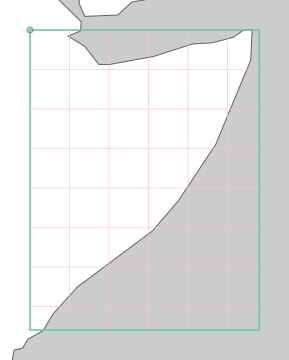

In [51]:
epsg = 4326
# create a geobox for consistent spatial reference
geobox, aoi = get_geobox_from_aoi(aoi_shape, epsg, resolution, chunksize_xy, return_aoi=True)
geobox

# Define area to download now
The data is requested from planetarycomputers, the subset is an example, we could ask for all scenes in the aoi at once by switching out geobox_subset.

In [52]:
geobox_subset, yx_index_slices = subset_geobox_by_bbox_chunkwise(geobox, epsg, lat, lon, resolution_in_utm, subset_size, chunksize_xy)

In [53]:
# catalog setup
stac = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(stac)  #, modifier=pc.sign_inplace)  # sign in place might get stale for longer processes
collection = 'sentinel-2-l2a'

items = catalog.search(
    intersects=geobox_subset.geographic_extent,
    datetime=f"{start_date}/{end_date}",
    collections=[collection],
).item_collection()

# Download the tiles, write new asset metadata and make cube from local data.

In [54]:
# strage space
out_path = '/Net/Groups/BGI/data/DataStructureMDI/DATA/Incoming/Sentinel/_2/S2A_L2A/ForSites/Sentinel2tiles'
os.makedirs(out_path, exist_ok=True)

In [55]:
avail_items, to_download = check_request_against_local(items, out_path,
                                                       requested_bands=requested_bands)

48 missing assets of 12 items to download.


In [56]:
# Create a SLURM cluster
cluster = SLURMCluster(
    queue='work',                  # Specify the SLURM queue
    cores=1,                          # Number of cores per job
    memory='500MB',                    # Memory per job
    walltime='03:00:00',              # Job duration (hh:mm:ss)
)

# Scale up the number of workers
# cluster.scale(jobs=8)  # Adjust the number of jobs/workers
cluster.adapt(minimum=1, maximum=20)

# Create a Dask client that connects to the cluster
client = Client(cluster)

# Check cluster status
cluster

/User/homes/mzehner/micromamba/envs/minicuber/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37221 instead
  warnings.warn(


Dashboard: http://10.0.30.56:37221/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.30.56:38779,Workers: 0
Dashboard: http://10.0.30.56:37221/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [57]:
tasks = [get_asset(*i) for i in to_download]
len(tasks)

48

In [58]:
dask.compute(*tasks)

(None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None)

In [59]:
client.close()
cluster.close()

# Get overview of the available data

In [60]:
all_local_avail_items = get_all_local_assets(out_path)

In [61]:
with open('all_local_avail_items.pkl', 'wb') as f:
    pickle.dump(all_local_avail_items, f)


In [62]:
leaflet_overview(pickle.load(open('all_local_avail_items.pkl', 'rb')))

# Load the requested data as xarray

In [63]:
ds_odc = odc.stac.load(
    all_local_avail_items,
    bands=requested_bands,
    chunks={'time': -1, 'x': chunksize_xy, 'y': chunksize_xy},
    geobox=geobox_subset,
    dtype='uint16',
    resampling='bilinear',
    groupby='solar_day'
)
ds_odc

<xarray.Dataset> Size: 1GB
Dimensions:      (latitude: 768, longitude: 768, time: 235)
Coordinates:
  * latitude     (latitude) float64 6kB 10.77 10.77 10.77 ... 10.63 10.63 10.63
  * longitude    (longitude) float64 6kB 47.25 47.25 47.25 ... 47.39 47.39 47.39
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 2kB 2021-01-04T07:13:09.024000 ... 202...
Data variables:
    B02          (time, latitude, longitude) uint16 277MB dask.array<chunksize=(235, 256, 256), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 277MB dask.array<chunksize=(235, 256, 256), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 277MB dask.array<chunksize=(235, 256, 256), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 277MB dask.array<chunksize=(235, 256, 256), meta=np.ndarray>

/User/homes/mzehner/micromamba/envs/minicuber/lib/python3.12/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(
/User/homes/mzehner/micromamba/envs/minicuber/lib/python3.12/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


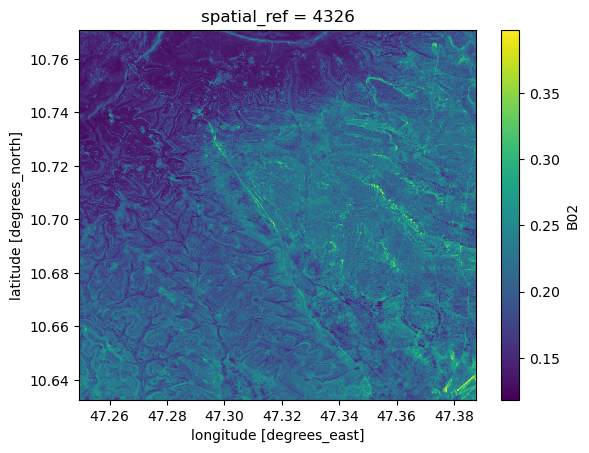

In [64]:
#ds_odc.isel(time=-1, latitude=slice(100,200), longitude=slice(100,200)).B02.plot.imshow()
(ds_odc.B02.where(ds_odc.B02 != 0, np.nan).median(dim='time')/10000).plot()

# Prepare to insert data into a larger consistent cube

In [65]:
# setup for large datacube
zarr_store = '/Net/Groups/BGI/scratch/mzehner/VCI_Somalia/Somalia_S2_2014_2026_dask_test.zarr'
chunksize_xy = 256
time_chunk_size = -1
requested_bands = ['B02', 'B03', 'B04', 'B8A']
start_date_zarr = '2014-01-01'
end_date_zarr = '2026-12-31'
# create an empty zarr file with the correct geobox
try:
    create_skeleton_zarr(geobox, zarr_store, 
                         chunksize_xy=chunksize_xy, 
                         time_chunk_size=time_chunk_size, 
                         dtype=np.uint16, 
                         bands=requested_bands, 
                         start_date=start_date_zarr, 
                         end_date=end_date_zarr, 
                         t_freq='1D',
                         overwrite=False)
except ContainsGroupError as e:
    print(f'Zarr already exists at {zarr_store}. Skipping creation.')

In [66]:
ds_odc = odc.stac.load(
    all_local_avail_items,
    bands=requested_bands,
    chunks={'time': -1, 'x': chunksize_xy, 'y': chunksize_xy},
    geobox=geobox_subset,
    dtype='uint16',
    resampling='bilinear',
    groupby='solar_day'
)
ds_odc = ds_odc.drop_vars(['spatial_ref'])
ds_odc['time'] = ds_odc.time.dt.floor('D')

In [67]:
min_time = ds_odc['time'].min().values
max_time = ds_odc['time'].max().values

t_start = (min_time - pd.to_datetime(start_date_zarr).to_numpy()).astype('timedelta64[D]').astype(int)
t_end = (max_time - pd.to_datetime(start_date_zarr).to_numpy()).astype('timedelta64[D]').astype(int)

if time_chunk_size > 0:
    print('Reindexing time dimension to match chunk size')
    t_start = t_start//time_chunk_size * time_chunk_size
    t_end = ((t_end//time_chunk_size)+1) * time_chunk_size
   
    t_reindex_start = start_date_zarr
    t_reindex_end = end_date_zarr
else:
    t_end += 1
    t_reindex_start = min_time
    t_reindex_end = max_time

t_index_slices = (t_start, t_end)
 

# reindex for consistent chunk dimensions, maybe there is a better way to do this
ds_odc = (ds_odc.reindex(time=pd.date_range(t_reindex_start, t_reindex_end, freq='1D'), 
                        fill_value=0, method='nearest')
                .chunk({'time': time_chunk_size, 
                        'latitude': chunksize_xy, 
                        'longitude': chunksize_xy}
                        )
        )
if time_chunk_size > 0:
        ds_odc = ds_odc.isel(time=slice(*t_index_slices))
ds_odc

<xarray.Dataset> Size: 6GB
Dimensions:    (latitude: 768, longitude: 768, time: 1336)
Coordinates:
  * latitude   (latitude) float64 6kB 10.77 10.77 10.77 ... 10.63 10.63 10.63
  * longitude  (longitude) float64 6kB 47.25 47.25 47.25 ... 47.39 47.39 47.39
  * time       (time) datetime64[ns] 11kB 2021-01-04 2021-01-05 ... 2024-08-31
Data variables:
    B02        (time, latitude, longitude) uint16 2GB dask.array<chunksize=(1336, 256, 256), meta=np.ndarray>
    B03        (time, latitude, longitude) uint16 2GB dask.array<chunksize=(1336, 256, 256), meta=np.ndarray>
    B04        (time, latitude, longitude) uint16 2GB dask.array<chunksize=(1336, 256, 256), meta=np.ndarray>
    B8A        (time, latitude, longitude) uint16 2GB dask.array<chunksize=(1336, 256, 256), meta=np.ndarray>

# Save the current cube into large dataset

In [68]:
tasks = []
for b in requested_bands:
    for x in range(0, len(ds_odc.longitude), chunksize_xy):
        for y in range(0, len(ds_odc.latitude), chunksize_xy):
            tasks.append(store_chunks_to_zarr(ds_odc, zarr_store, b, t_index_slices, yx_index_slices, chunksize_xy, x, y))

In [72]:
# Create a SLURM cluster
# Create a SLURM cluster
cluster = SLURMCluster(
    queue='work',                  # Specify the SLURM queue
    cores=1,                          # Number of cores per job
    memory='32GB',                    # Memory per job
    walltime='03:00:00',              # Job duration (hh:mm:ss)
)

# Scale up the number of workers
# cluster.scale(jobs=8)  # Adjust the number of jobs/workers
cluster.adapt(minimum=1, maximum=20)

# Create a Dask client that connects to the cluster
client = Client(cluster)

# Check cluster status
cluster
# # Create delayed tasks
# tasks = [fixed_function(i) for i in requested_bands]
# Trigger the execution of these tasks in parallel
# dask.compute(*tasks)

Dashboard: http://10.0.30.56:37399/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.30.56:33593,Workers: 0
Dashboard: http://10.0.30.56:37399/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [73]:
dask.compute(*tasks)


(None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None)

In [74]:

client.close()
cluster.close()

# Address the large dataset

In [75]:
data_large = xr.open_zarr(zarr_store, mask_and_scale=False)
data_large

<xarray.Dataset> Size: 168TB
Dimensions:      (time: 4748, latitude: 75990, longitude: 58076)
Coordinates:
  * latitude     (latitude) float64 608kB 12.01 12.01 12.01 ... -1.663 -1.663
  * longitude    (longitude) float64 465kB 40.98 40.98 40.98 ... 51.44 51.44
    spatial_ref  int32 4B ...
  * time         (time) datetime64[ns] 38kB 2014-01-01 2014-01-02 ... 2026-12-31
Data variables:
    B02          (time, latitude, longitude) uint16 42TB dask.array<chunksize=(4748, 256, 256), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 42TB dask.array<chunksize=(4748, 256, 256), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 42TB dask.array<chunksize=(4748, 256, 256), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 42TB dask.array<chunksize=(4748, 256, 256), meta=np.ndarray>

# Addressing the large dataset as a minicube

In [76]:
mc = mc_from_chunk(10.7, 47.3, data_large)
mc

<xarray.Dataset> Size: 2GB
Dimensions:      (time: 4748, latitude: 256, longitude: 256)
Coordinates:
  * latitude     (latitude) float64 2kB 10.72 10.72 10.72 ... 10.68 10.68 10.68
  * longitude    (longitude) float64 2kB 47.3 47.3 47.3 ... 47.34 47.34 47.34
    spatial_ref  int32 4B ...
  * time         (time) datetime64[ns] 38kB 2014-01-01 2014-01-02 ... 2026-12-31
Data variables:
    B02          (time, latitude, longitude) uint16 622MB dask.array<chunksize=(4748, 256, 256), meta=np.ndarray>
    B03          (time, latitude, longitude) uint16 622MB dask.array<chunksize=(4748, 256, 256), meta=np.ndarray>
    B04          (time, latitude, longitude) uint16 622MB dask.array<chunksize=(4748, 256, 256), meta=np.ndarray>
    B8A          (time, latitude, longitude) uint16 622MB dask.array<chunksize=(4748, 256, 256), meta=np.ndarray>

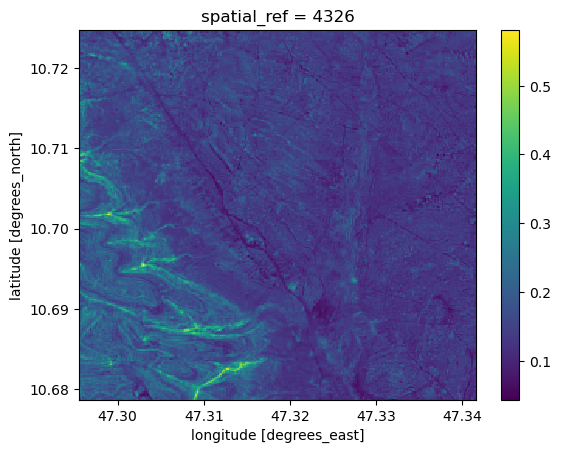

In [77]:
def ndvi(band_red, band_nir):
    return (band_nir - band_red) / (band_nir + band_red)

mc_float = mc.where(mc.B02 != 0, np.nan).dropna(dim='time', how='all')

ndvi(mc_float.B04.mean(dim='time'), mc_float.B8A.mean(dim='time')).plot.imshow()
